In [1]:
import cv2
import Tkinter as tk
import tkFileDialog
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from Preprocessing import load_images
from keras.utils import np_utils
from sklearn import metrics as sk
from sklearn.metrics import cohen_kappa_score
import datumio.datagen as dtd
np.random.seed(200)
%matplotlib inline

Using TensorFlow backend.


In [2]:
tk.Tk().withdraw()
path_Train=tkFileDialog.askdirectory()
print path_Train

/home/edward/Skin-Lesion-Analysis-Towards-Melanoma-Detection/Training Images


In [3]:
X_Train=load_images(path_Train)

In [4]:
type(X_Train)

list

In [5]:
X_Train=np.array(X_Train)
X_Train.shape

(2000, 64, 64, 3)

In [6]:
#X_Train=np.reshape(X_Train,[-1,np.prod(X_Train.shape[1:])])
#X_Train.shape

In [7]:
tk.Tk().withdraw()
path_Test=tkFileDialog.askdirectory()
print path_Test

/home/edward/Skin-Lesion-Analysis-Towards-Melanoma-Detection/Testing Images


In [8]:
X_Test=load_images(path_Test)
X_Test=np.array(X_Test)

In [9]:
#X_Test=np.reshape(X_Test,[-1,np.prod(X_Test.shape[1:])])
#X_Test.shape

In [10]:
data_Train=pd.read_csv("/home/edward/Skin-Lesion-Analysis-Towards-Melanoma-Detection/ISIC-2017_Training_Part3_GroundTruth.csv")
data_Test=pd.read_csv("/home/edward/Skin-Lesion-Analysis-Towards-Melanoma-Detection/ISIC-2017_Test_v2_Part3_GroundTruth.csv")

In [11]:
data_Train=data_Train.iloc[0:2000,1]
data_Test=data_Test.iloc[0:600,1]
print data_Train.shape
print data_Test.shape

(2000,)
(600,)


In [12]:
y_Train=data_Train
y_Test=data_Test

In [13]:
y_Train=np.array(y_Train)
y_Test=np.array(y_Test)

In [14]:
y_Train = np_utils.to_categorical(data_Train)
y_Test = np_utils.to_categorical(data_Test)
print y_Train.shape
print y_Test.shape

(2000, 2)
(600, 2)


In [15]:
tk.Tk().withdraw()
path_Validation=tkFileDialog.askdirectory()
print path_Validation
X_Val=load_images(path_Validation)
X_Val=np.array(X_Val)
X_Val.shape

/home/edward/Skin-Lesion-Analysis-Towards-Melanoma-Detection/Validation Images


(150, 64, 64, 3)

In [16]:
y_Val=pd.read_csv("/home/edward/Skin-Lesion-Analysis-Towards-Melanoma-Detection/ISIC-2017_Validation_Part3_GroundTruth.csv")
Data_Validation=y_Val.iloc[0:150,1]
print y_Val.shape
y_Val = np_utils.to_categorical(Data_Validation)
print y_Val.shape

(150, 3)
(150, 2)


In [17]:
def center_normalize(x):
    return (x-np.mean(x))/np.std(x)
X_Train=center_normalize(X_Train)
X_Test=center_normalize(X_Test)

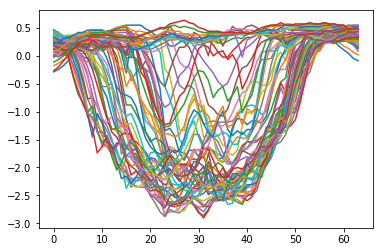

In [18]:
plt.plot(X_Train[0,:,:,2])

In [19]:
aug_params={'rotation_range':(-20,20),
           'translation_range':(-4,4),
           'do_flip_lr':True}
batch_generator=dtd.BatchGenerator(X_Train,y=y_Train,rng_aug_params=aug_params)

#### Placeholders and inputs

In [20]:
sess=tf.Session()
img_size=64
num_channels=3
num_classes=2
img_size_flat=img_size*img_size*num_channels
with tf.name_scope("Input"):
    x=tf.placeholder(tf.float32,shape=[None,img_size_flat],name='x')
    x=tf.reshape(x,[-1,img_size,img_size,num_channels])
logs_path = '/tmp/tensorflow_logs/example'
model_path = "/home/edward/Trained models/Final.ckpt"
y_true=tf.placeholder(tf.float32,shape=[None,num_classes],name='y_true')
y_true_cls=tf.argmax(y_true,dimension=1)
dropout=0.75
with tf.name_scope('dropout'):
    keep_prob=tf.placeholder(tf.float32)
    tf.summary.scalar('dropout_keep_probability', keep_prob)

filter_size1=3
num_filters1=32
filter_size2=3
num_filters2=32
filter_size3=3
num_filters3=32
filter_size4=3
num_filters4=32
filter_size5=3
num_filters5=32
fc_size=32

#### Initilization of Weights

In [21]:
def weights_initilization(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.05))
def biases_initilization(length):
    return tf.Variable(tf.random_normal(shape=[length]))

#### Convolution + pooling layer

In [22]:
def conv_layer(input,input_channels,filter_size,num_filters,layer_name,use_pooling=True):
    with tf.name_scope(layer_name):
        shape=[filter_size,filter_size,input_channels,num_filters]
        with tf.name_scope('Weights'):
            weights=weights_initilization(shape)
            variable_summaries(weights)
        with tf.name_scope("Biases"):
            biases=biases_initilization(length=num_filters)
            variable_summaries(biases)
        conv_layer=tf.nn.conv2d(input=input,filter=weights,strides=[1,1,1,1],padding='SAME')
        conv_layer+=biases

        if use_pooling:
            pooling_layer=tf.nn.max_pool(value=conv_layer,ksize=[1,2,2,1],
                                        strides=[1,2,2,1],padding='SAME')
            Activation_layer=tf.nn.relu(pooling_layer)
        else:
            Activation_layer=conv_layer
    return Activation_layer,weights

#### Flatten layer 

In [23]:
def flatten_layer(layer,layer_name):
    with tf.name_scope(layer_name):
        layer_shape=layer.get_shape()
        num_features=layer_shape[1:4].num_elements()
        layer_flat=tf.reshape(layer,[-1,num_features])
    return layer_flat,num_features

#### Fully Connected layer

In [24]:
def fc_layer(input,num_inputs,num_outputs,layer_name,keep_prob,use_relu=True):
    with tf.name_scope(layer_name):
        with tf.name_scope("Weights_FC"):
            weights=weights_initilization(shape=[num_inputs,num_outputs])
            variable_summaries(weights)
        with tf.name_scope("biases_FC"):
            biases=biases_initilization(length=num_outputs)
            variable_summaries(biases)
        with tf.name_scope("Wx_plus_b"):
            layer=tf.matmul(input,weights)+biases
            tf.summary.histogram('Preactivation',layer)
        with tf.name_scope('Activation'):
            if use_relu:
                layer=tf.nn.relu(layer)
                tf.summary.histogram('activation',layer)
        with tf.name_scope('dropout'):
            layer=tf.nn.dropout(layer,keep_prob)
    return layer,weights

In [25]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)

#### Network Design

In [26]:
layer_conv1,weights_conv1=conv_layer(input=x,input_channels=num_channels,filter_size=filter_size1,
                                     num_filters=num_filters1,layer_name='layer1',use_pooling=True)
layer_conv2,weights_conv2=conv_layer(input=layer_conv1,input_channels=num_filters2,filter_size=filter_size2,
                                     num_filters=num_filters2,use_pooling=True,layer_name='layer2')
layer_conv3,weights_conv3=conv_layer(input=layer_conv2,input_channels=num_filters3,filter_size=filter_size3,
                                     num_filters=num_filters3,use_pooling=True,layer_name='layer3')
layer_flat,num_features=flatten_layer(layer_conv3,'layer4')
layer_fc1,weights_FC1=fc_layer(input=layer_flat,num_inputs=num_features,num_outputs=num_classes,keep_prob=keep_prob,layer_name='layer5',use_relu=True)
#layer_fc2,weights_FC2=fc_layer(input=layer_fc1,num_inputs=fc_size,num_outputs=num_classes,keep_prob=keep_prob,layer_name='layer17',use_relu=True)


In [27]:
#layer_fc2

#### Predications

In [28]:
y_pred=tf.nn.softmax(layer_fc1)
y_pred_cls=tf.argmax(y_pred,dimension=1)
with tf.name_scope('cross_entropy'):
    cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc1,labels=y_true)
with tf.name_scope("total"):  
    cost=tf.reduce_mean(cross_entropy)
tf.summary.scalar('cost',cost)

<tf.Tensor 'cost:0' shape=() dtype=string>

#### Optimization

In [29]:
with tf.name_scope('train'):
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-04).minimize(cross_entropy)
with tf.name_scope("Accuracy"):
    with tf.name_scope('correct_prediction'):
        correct_prediction=tf.equal(y_pred_cls,y_true_cls)
    with tf.name_scope('accuracy'):
        accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
tf.summary.scalar('accuracy', accuracy)
#tf.summary.scalar('correct_prediction',correct_prediction)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

In [30]:
batch_size=100
merged=tf.summary.merge_all()
train_writer=tf.summary.FileWriter(logs_path+'/train',sess.graph)
test_writer=tf.summary.FileWriter(logdir=logs_path+"/test")
sess.run(tf.global_variables_initializer())
with sess.as_default():
    tf.global_variables_initializer().run()
train_batch_size=batch_size

In [31]:
# save model 
model_saver=tf.train.Saver()

In [32]:
def print_progress(epoch,feed_dict_train,feed_dict_test,test_loss):
    acc=sess.run(accuracy,feed_dict=feed_dict_train)
    test_acc=sess.run(accuracy,feed_dict=feed_dict_test)
    
    msg="Epoch {0} --- Training Accuracy:{1:>6.1%},Testing Accuracy:{2:>6.1%}, Test Loss:{3:.3f}"
    print msg.format(epoch+1,acc,test_acc,test_loss)

In [33]:
total_iterations=0
batch_size=100
img_size_flat=img_size*img_size*num_channels
def optimize(num_iterations):
      # uncomment below two line while you are restoring model
    #load_path = saver_sigmoid.restore(sess, model_path)
    #print "Model restored from file: %s" % save_path
    global total_iterations
    best_test_loss=float("inf")
    summary_writer=tf.summary.FileWriter(logs_path,graph=sess.graph)
    for i in range(total_iterations,total_iterations+num_iterations):
        for batch in batch_generator.get_batch(batch_size=batch_size,shuffle=True):
             feed_dict_train = {x: batch[0],
                           y_true: batch[1],keep_prob:dropout}
        train_idx=np.random.randint(X_Test.shape[0],size=batch_size)
        batch_x_Test=X_Test[train_idx,:]
        batch_y_Test=y_Test[train_idx]
       
        
        feed_dict_test = {x: batch_x_Test,
                              y_true: batch_y_Test,keep_prob:1.0}
        _,c,summary=sess.run([optimizer,cost,merged],feed_dict=feed_dict_train)
        if i% int(X_Train.shape[0]/batch_size)==0:
            test_loss=sess.run(cost,feed_dict=feed_dict_test)
            epoch=int(i/(X_Train.shape[0]/batch_size))
            summary_writer.add_summary(summary,epoch*batch_size+i)
            print_progress(epoch,feed_dict_train,feed_dict_test,test_loss)
        total_iterations+=num_iterations
    save_path=model_saver.save(sess,model_path)
    print "Model saved in file: %s" % save_path

In [34]:
optimize(num_iterations=1000)

Epoch 1 --- Training Accuracy: 34.0%,Testing Accuracy: 20.0%, Test Loss:1.170
Epoch 2 --- Training Accuracy: 83.0%,Testing Accuracy: 83.0%, Test Loss:0.555
Epoch 3 --- Training Accuracy: 78.0%,Testing Accuracy: 75.0%, Test Loss:0.565
Epoch 4 --- Training Accuracy: 79.0%,Testing Accuracy: 81.0%, Test Loss:0.495
Epoch 5 --- Training Accuracy: 82.0%,Testing Accuracy: 75.0%, Test Loss:0.561
Epoch 6 --- Training Accuracy: 79.0%,Testing Accuracy: 76.0%, Test Loss:0.558
Epoch 7 --- Training Accuracy: 81.0%,Testing Accuracy: 79.0%, Test Loss:0.515
Epoch 8 --- Training Accuracy: 94.0%,Testing Accuracy: 78.0%, Test Loss:0.532
Epoch 9 --- Training Accuracy: 82.0%,Testing Accuracy: 77.0%, Test Loss:0.535
Epoch 10 --- Training Accuracy: 88.0%,Testing Accuracy: 77.0%, Test Loss:0.542
Epoch 11 --- Training Accuracy: 78.0%,Testing Accuracy: 74.0%, Test Loss:0.575
Epoch 12 --- Training Accuracy: 83.0%,Testing Accuracy: 75.0%, Test Loss:0.557
Epoch 13 --- Training Accuracy: 87.0%,Testing Accuracy: 74.0%

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_p = tf.argmax(layer_fc1, 1)
    val_accuracy, y_pr = sess.run([accuracy, y_p], feed_dict={x:X_Test, y_true:y_Test,keep_prob:dropout})
    y_true = np.argmax(y_Test,1)
    print "Precision", sk.precision_score(y_true, y_pr)
    print "Recall", sk.recall_score(y_true, y_pr)
    print "confusion_matrix"
    print sk.confusion_matrix(y_true, y_pr)
    print "kappa score",cohen_kappa_score(y_true,y_pr)
    auc = sk.roc_auc_score(y_true, y_pr)
    #print "fpr",fpr
    #print "tpr",tpr
    #print tresholds
    print 'auc',auc

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_p = tf.argmax(layer_fc1, 1)
    val_accuracy, y_pr = sess.run([accuracy, y_p], feed_dict={x:X_Val, y_true:y_Val,keep_prob:dropout})
    y_true = np.argmax(y_Val,1)
    print "Precision", sk.precision_score(y_true, y_pr)
    print "Recall", sk.recall_score(y_true, y_pr)
    print "confusion_matrix"
    print sk.confusion_matrix(y_true, y_pr)
    print "kappa score",cohen_kappa_score(y_true,y_pr)
    auc = sk.roc_auc_score(y_true, y_pr)
    #print "fpr",fpr
    #print "tpr",tpr
    #print tresholds
    print 'auc',auc